In [1]:
import cadquery as cq

from OCP.gp import gp_Pnt
from OCP.TColgp import TColgp_Array1OfPnt
from OCP.TColStd import TColStd_Array1OfInteger, TColStd_Array1OfReal
from OCP.Geom import Geom_BSplineCurve
from OCP.BRepBuilderAPI import BRepBuilderAPI_MakeEdge

import numpy as np
from scipy.interpolate import splprep, InterpolatedUnivariateSpline, UnivariateSpline
from jupyter_cadquery import show
import matplotlib.pyplot as plt

import splinecloud_scipy as sc

Overwriting auto display for cadquery Workplane and Shape


## Airfoil B-Spline data

In [2]:
degree = 3

In [3]:
airfoil_knots = [0, 0.27126526377831234, 0.48788651718430687, 0.7126821575112824, 1]

In [4]:
airfoil_control_points = [
    [1, 0.000599299999999952],
    [0.5903084290690273, 0.09709044559810814],
    [0.16053266616329936, 0.10390785536734934],
    [-0.013154877803984444, 0.017472696717591888],
    [-0.007082643051840989, -0.04825576822658678],
    [0.41783319693438964, -0.020080991735084767],
    [1, -0.0005451233447249099]
]

## Construct OCC B-Spline from Knots, Knot multiplicities, control points and degree

In [5]:
def build_spline(knot_vector, control_points, degree):
    
    knot_mults = list(map(lambda k: degree+1 if k in (0,1) else 1, knot_vector))

    poles = TColgp_Array1OfPnt(1, len(control_points))
    for i, cp in enumerate(control_points):
        poles.SetValue(i+1, gp_Pnt(cp[0], cp[1], 0))
        
    knots = TColStd_Array1OfReal(1, len(knot_vector))
    for i, k in enumerate(knot_vector):
        knots.SetValue(i+1, k)
        
    mults = TColStd_Array1OfInteger(1, len(knot_mults))
    for i, m in enumerate(knot_mults):
        mults.SetValue(i+1, m)
        
    bspl = Geom_BSplineCurve(poles, knots, mults, degree)
    
    return bspl 

In [6]:
airfoil_bspl = build_spline(airfoil_knots, airfoil_control_points, degree)

## Construct CQ geometry

In [7]:
airfoil_edge = cq.Edge(BRepBuilderAPI_MakeEdge(airfoil_bspl).Edge())

In [8]:
airfoil_sketch = cq.Sketch().edge(airfoil_edge).close().assemble()
airfoil_sketch

CadViewerWidget(anchor=None, cad_width=800, glass=False, height=600, pinning=False, theme='light', title=None,…

In [9]:
airfoil_body = cq.Workplane().placeSketch(airfoil_sketch).extrude(1)
airfoil_body

CadViewerWidget(anchor=None, cad_width=800, glass=False, height=600, pinning=False, theme='light', title=None,…

## Load profile data from SplineCloud

In [10]:
# profile_data = sc.LoadSubset("sbt_XcZUwUj5CuZf")
# profile_data = sc.LoadSubset("sbt_tnZbUHv0uTGO")
# profile_data = sc.LoadSubset("sbt_38mLwhFXLXlD")
# profile_data = sc.LoadSubset("sbt_oll9JwctqjUx")
# profile_data = sc.LoadSubset("sbt_yoL4MzV19cyD")
profile_data = sc.LoadSubset("sbt_S0woIPGIlbwm")

In [11]:
airfoil_profile_points = profile_data.values.tolist()

### Analize profile data

In [12]:
sharp_tail = (
    airfoil_profile_points[0][0] == airfoil_profile_points[-1][0]
    and 
    airfoil_profile_points[0][1] == airfoil_profile_points[-1][1]
)

In [13]:
def thicken_sharp_tail(profile_points):
    """
    Patch tail points to avoid malformed geometry construction
    and enable shell creation in CadQuery
    """
    thicken_ratio = 0.3 # share of profile height at neighboring points

    ## height at the first point pair after the tail point
    h1 = profile_points[1][1] - profile_points[-2][1] 
    h0 = min(h1 * thicken_ratio, 0.001)

    profile_points[0][1] = profile_points[0][1] + h0/2
    profile_points[-1][1] = profile_points[-1][1] - h0/2

In [14]:
if sharp_tail:
    thicken_sharp_tail(airfoil_profile_points)
    sharp_tail = False

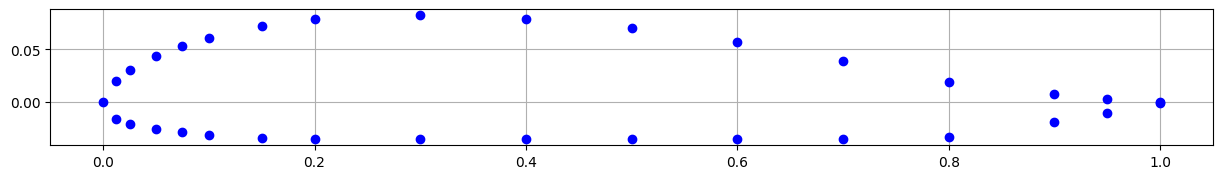

In [15]:
px, py = zip(*airfoil_profile_points)

plt.rcParams['figure.figsize'] = [15, 15]
plt.plot(px, py, 'bo')
plt.grid()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.show()

## Build profile curve

In [16]:
def bspl_approx_profile(profile_points, s=2e-5, k=3):
    """
    B-Spline approximation of the discrete profile data, represented in Selig format
    
    Paameters:
    'pp' - array of [x,y] coords
    's' - smoothing factor
    'k' - spline degree
    
    Returns:
    't', 'cx',  - B-Spline represntation, instances of the SplineCloud ParametricUnivariateSpline
    """
    xvals = [p[0] for p in profile_points]
    yvals = [p[1] for p in profile_points]
    
    ## set weights to critical profile points
    weight_mod = lambda x: 20 if x==0.0 else (5 if x==1.0 else 1)
    weights = list(map(weight_mod, xvals))
    
    tck, u = splprep([xvals, yvals], s=s, k=k, w=weights)
    t, c, k = tck
    cx, cy = c
    
    ## adjust spline end points to match profile points
    cx[0], cy[0] = profile_points[0]
    cx[-1], cy[-1] = profile_points[-1]
       
    return t[k:-k], np.array(list(zip(cx, cy))), k

In [17]:
t, c, k = bspl_approx_profile(airfoil_profile_points)

In [18]:
c = c*100 ## scale geometry 

In [19]:
airfoil_bspl = build_spline(t, c, k)

In [20]:
airfoil_edge = cq.Edge(BRepBuilderAPI_MakeEdge(airfoil_bspl).Edge())

In [21]:
airfoil_edge

CadViewerWidget(anchor=None, cad_width=800, glass=False, height=600, pinning=False, theme='light', title=None,…

In [22]:
if sharp_tail:
    airfoil_sketch = cq.Sketch().edge(airfoil_edge).assemble()
else:
    airfoil_sketch = cq.Sketch().edge(airfoil_edge).close().assemble()

airfoil_sketch

CadViewerWidget(anchor=None, cad_width=800, glass=False, height=600, pinning=False, theme='light', title=None,…

In [23]:
airfoil_body = cq.Workplane().placeSketch(airfoil_sketch).extrude(100)
airfoil_body

CadViewerWidget(anchor=None, cad_width=800, glass=False, height=600, pinning=False, theme='light', title=None,…

In [24]:
shell = airfoil_body.faces(">Z or <Z").shell(1)

In [25]:
shell

CadViewerWidget(anchor=None, cad_width=800, glass=False, height=600, pinning=False, theme='light', title=None,…

In [26]:
shell_volume = shell.solids().vals()[0].Volume()

In [27]:
body_volume = airfoil_body.solids().vals()[0].Volume()

In [28]:
body_volume / shell_volume

4.697027026627288